In [ ]:
!pip install pystan==2.19.1.1


In [ ]:
import pystan
import pandas as pd


In [ ]:
data_df = pd.read_csv('merged_VTA_stan.csv')


In [ ]:
# Count the number of subjects (N)
N = data_df['subjid'].nunique()

# Identify the maximum number of trials (T)
T = data_df.groupby('subjid').size().max()

# Determine the number of trials within each subject (Tsubj)
Tsubj = data_df.groupby('subjid').size().values

# Create placeholders with -1 (as per Stan data declaration)
cond = -1 * pd.DataFrame(index=range(N), columns=range(T)).fillna(-1).astype(int).values
decisions = -1 * pd.DataFrame(index=range(N), columns=range(T)).fillna(-1).astype(int).values
outcomes = -1 * pd.DataFrame(index=range(N), columns=range(T)).fillna(-1).astype(int).values
new_block = -1 * pd.DataFrame(index=range(N), columns=range(T)).fillna(-1).astype(int).values

# Populate the placeholders with actual data
for idx, subj_data in data_df.groupby('subjid'):
    trial_len = len(subj_data)
    cond[idx-1, :trial_len] = subj_data['cond'].values
    decisions[idx-1, :trial_len] = subj_data['decisions'].values
    outcomes[idx-1, :trial_len] = subj_data['outcomes'].values
    new_block[idx-1, :trial_len] = (subj_data['block'].diff() != 0).astype(int).values
    new_block[idx-1, 0] = 1  # First trial always starts a new block

stan_data = {
    'N': N,
    'T': T,
    'Tsubj': Tsubj,
    'cond': cond,
    'decisions': decisions,
    'outcomes': outcomes,
    'new_block': new_block
}


In [ ]:
# Define your Stan model
stan_code = """
data {
  int<lower=1> N;                               // # of subjects
  int<lower=1> T;                               // max # of trials
  int<lower=1, upper=T> Tsubj[N];               // # of trials within subjects
  int<lower=-1, upper=3> cond[N, T];            // trial condition
  int<lower=-1, upper=2> decisions[N, T];       // decisions
  int<lower=-1, upper=1> outcomes[N, T];        // outcomes
  int<lower=-1, upper=1> new_block[N, T];       // new block indicator to reset Q-values
}

transformed data {
  // Define dimensions for initV
  int<lower=1> num_conditions = 3;
  int<lower=1> num_actions = 2;

  real initV[3, 2];
  for (i in 1:num_conditions) {
    for (j in 1:num_actions) {
      initV[i, j] = 0.0;
    }
  }
}

parameters {
  // Declare all parameters as vectors for vectorizing
  // Hyper(group)-parameters
  vector[6] mu_pr;
  vector<lower=0>[6] sigma;

  // Subject-level raw parameters (for Matt trick)
  vector[N] Arew_pr;
  vector[N] Apun_pr;
  vector[N] Aneu_pr;
  vector[N] Brew_pr;
  vector[N] Bpun_pr;
  vector[N] Bneu_pr;
}

transformed parameters {
  // Transform subject-level raw parameters
  vector<lower=0, upper=1>[N] Arew;
  vector<lower=0, upper=1>[N] Apun;
  vector<lower=0, upper=1>[N] Aneu;
  vector<lower=0>[N] Brew;
  vector<lower=0>[N] Bpun;
  vector<lower=0>[N] Bneu;

  for (i in 1:N) {
    Arew[i] = Phi_approx(mu_pr[1] + sigma[1] * Arew_pr[i]);
    Apun[i] = Phi_approx(mu_pr[2] + sigma[2] * Apun_pr[i]);
    Aneu[i] = Phi_approx(mu_pr[3] + sigma[3] * Aneu_pr[i]);
    Brew[i] = exp(mu_pr[4] + sigma[4] * Brew_pr[i]);
    Bpun[i] = exp(mu_pr[5] + sigma[5] * Bpun_pr[i]);
    Bneu[i] = exp(mu_pr[6] + sigma[6] * Bneu_pr[i]);
  }
}

model {
  // Hyperparameters
  mu_pr ~ normal(0, 1);
  sigma ~ normal(0, 0.2);

  // individual parameters
  Arew_pr  ~ normal(0, 1.0);
  Apun_pr  ~ normal(0, 1.0);
  Aneu_pr  ~ normal(0, 1.0);
  Brew_pr  ~ normal(0, 1.0);
  Bpun_pr  ~ normal(0, 1.0);
  Bneu_pr  ~ normal(0, 1.0);

  for (i in 1:N) {
    // Define values
    real Q[3, 2];     // expected value table
    real A;           // trial-level learning rate
    real B;           // trial-level sensitivity
    real PE;          // prediction error

    // Initialize values
    if (new_block[i, 1] == 1) {
      Q = initV;
    }

    // Which state/stimuli?
    if (cond[i, 1] == 1) {
      A = Arew[i];
      B = Brew[i];
    } else if (cond[i, 1] == 2) {
      A = Apun[i];
      B = Bpun[i];
    } else {
      A = Aneu[i];
      B = Bneu[i];
    }

    for (t in 1:Tsubj[i]) {
      // Initialize values
      if (new_block[i, t] == 1) {
        Q = initV;
      }

      // decisions
      decisions[i, t] ~ categorical(softmax(to_vector(Q[cond[i, t], ])));

      // Prediction error signals
      PE = B * outcomes[i, t] - Q[cond[i, t], decisions[i, t]];

      // Learning
      Q[cond[i, t], decisions[i, t]] += A * PE;
    }
  }
}

generated quantities {
  // For group level parameters
  real<lower=0, upper=1> mu_Arew;
  real<lower=0, upper=1> mu_Apun;
  real<lower=0, upper=1> mu_Aneu;
  real<lower=0> mu_Brew;
  real<lower=0> mu_Bpun;
  real<lower=0> mu_Bneu;

  // For log likelihood calculation
  real log_lik[N];

  // For posterior predictive check
  matrix[N, T] y_pred;

  // For prediction errors
  matrix[N, T] pred_error;

  mu_Arew = Phi_approx(mu_pr[1]);
  mu_Apun = Phi_approx(mu_pr[2]);
  mu_Aneu = Phi_approx(mu_pr[3]);
  mu_Brew = exp(mu_pr[4]);
  mu_Bpun = exp(mu_pr[5]);
  mu_Bneu = exp(mu_pr[6]);

  for (i in 1:N) {
    // Define values
    real Q[3, 2];     // expected value table
    real A;           // trial-level learning rate
    real B;           // trial-level sensitivity
    real PE;          // prediction error

    // Initialize values
    if (new_block[i, 1] == 1) {
      Q = initV;
    }

    // Which state/stimuli?
    if (cond[i, 1] == 1) {
      A = Arew[i];
      B = Brew[i];
    } else if (cond[i, 1] == 2) {
      A = Apun[i];
      B = Bpun[i];
    } else {
      A = Aneu[i];
      B = Bneu[i];
    }

    for (t in 1:Tsubj[i]) {
      // Initialize values
      if (new_block[i, t] == 1) {
        Q = initV;
      }

      // compute log likelihood of current trial
      log_lik[i] += categorical_lpmf(decisions[i, t] | softmax(to_vector(Q[cond[i, t], ])));

      // generate posterior prediction for current trial
      y_pred[i, t] = categorical_rng(softmax(to_vector(Q[cond[i, t],])));

      // Prediction error signals
      PE = B * outcomes[i, t] - Q[cond[i, t], decisions[i, t]];

      // Store prediction error
      pred_error[i, t] = PE;

      // Learning
      Q[cond[i, t], decisions[i, t]] += A * PE;
    }
  }
}

"""



In [ ]:
# Compile the model
sm = pystan.StanModel(model_code=stan_code)

In [ ]:
fit = sm.sampling(data=stan_data, iter=4000, warmup=2000, chains=4, seed=123, refresh=400)



To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [ ]:
fit_summary = fit.summary()
print(fit_summary)


In [ ]:
rhats = fit_summary['summary'][:, -1]
if all(rhats < 1.05):
    print("All R-hat values are below 1.05, indicating potential convergence.")
else:
    print("Some R-hat values exceed 1.05, indicating potential lack of convergence.")


Some R-hat values exceed 1.05, indicating potential lack of convergence.


In [ ]:
problematic_parameters = fit_summary['summary_rownames'][rhats > 1.05]
print("Parameters with potential convergence issues:", problematic_parameters)


Parameters with potential convergence issues: []


In [ ]:
!pip install arviz


In [ ]:
import arviz as az

idata = az.from_pystan(fit)


/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (22), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'mu_pr'}>,
        <Axes: title={'center': 'mu_pr'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'Arew_pr'}>,
        <Axes: title={'center': 'Arew_pr'}>],
       [<Axes: title={'center': 'Apun_pr'}>,
        <Axes: title={'center': 'Apun_pr'}>],
       [<Axes: title={'center': 'Aneu_pr'}>,
        <Axes: title={'center': 'Aneu_pr'}>],
       [<Axes: title={'center': 'Brew_pr'}>,
        <Axes: title={'center': 'Brew_pr'}>],
       [<Axes: title={'center': 'Bpun_pr'}>,
        <Axes: title={'center': 'Bpun_pr'}>],
       [<Axes: title={'center': 'Bneu_pr'}>,
        <Axes: title={'center': 'Bneu_pr'}>],
       [<Axes: title={'center': 'Arew'}>,
        <Axes: title={'center': 'Arew'}>],
       [<Axes: title={'center': 'Apun'}>,
        <Axes: title={'center': 'Apun'}>],
       [<Axes: title={'center': 'Aneu'}>,
        <Axes: title={'center': 'Aneu'}>],
       [<Axes: title={'ce

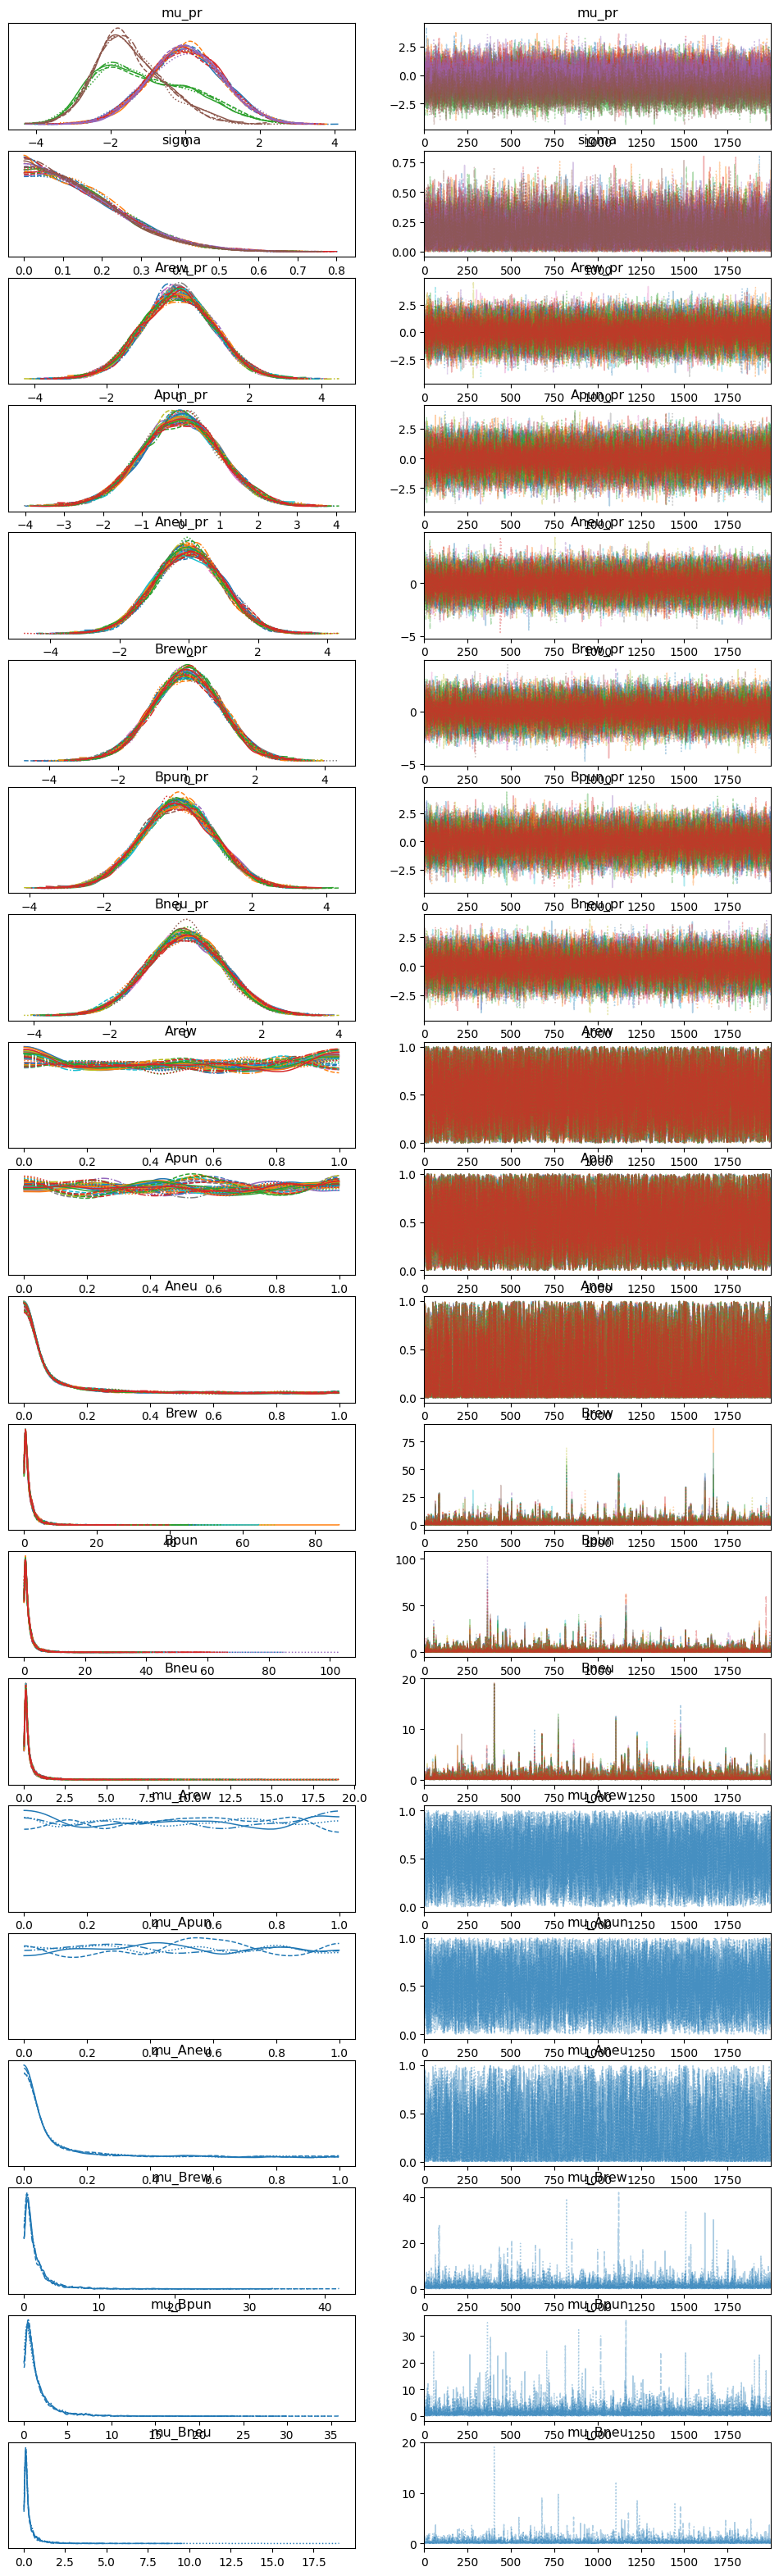

In [ ]:
az.plot_trace(idata)


In [ ]:
print(fit)


Inference for Stan model: anon_model_85a2e7bacfddafd57f8eabea10d96b0b.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

                       mean se_mean     sd    2.5%    25%     50%    75%   97.5%  n_eff   Rhat
mu_pr[1]              -0.01  8.6e-3    1.0   -1.98  -0.69   -0.03   0.67    1.95  13649    1.0
mu_pr[2]               0.01  8.7e-3    1.0   -1.92  -0.67    0.02   0.68    1.94  13004    1.0
mu_pr[3]              -1.45    0.01   0.85   -2.81  -2.01   -1.57  -1.01    0.67   5972    1.0
mu_pr[4]              -0.02  8.8e-3   0.97   -1.94  -0.67   -0.01   0.62    1.85  12176    1.0
mu_pr[5]            -1.5e-3  8.9e-3    1.0   -1.99  -0.65 -2.3e-3   0.68    1.93  12660    1.0
mu_pr[6]              -0.94    0.01   0.94   -2.71  -1.58   -0.97  -0.31     1.0   6026    1.0
sigma[1]               0.16  1.2e-3   0.12  6.2e-3   0.06    0.14   0.23    0.45  10642    1.0
sigma[2]               0.16  1.1e-3   0.12  7.2e-3 

In [ ]:
fit_summary

In [ ]:
samples = fit.extract()

In [ ]:
Arew_samples = samples['Arew']


In [ ]:
pred_errors = samples['pred_error']


In [ ]:
pred_errors

In [ ]:
Arew_samples

In [ ]:
pip install numpy

In [ ]:
import numpy as np  # Import the NumPy library

In [ ]:
# Extract Tsubj values from data_df
Tsubj = data_df.groupby("subjid")["block"].max().values

# 1. Extract the prediction errors
pred_errors = fit['pred_error']

# 2. Calculate the mean prediction errors for each participant across all chains and iterations
mean_pred_errors = np.mean(pred_errors, axis=0)

# 3. Convert these mean prediction errors into a DataFrame
mean_pred_errors_df = pd.DataFrame(mean_pred_errors, columns=[f"Trial_{i+1}" for i in range(mean_pred_errors.shape[1])])

# 4. Display the first few rows of this DataFrame
print(mean_pred_errors_df.head())


   Trial_1  Trial_2  Trial_3   Trial_4   Trial_5   Trial_6   Trial_7  \
0      0.0      0.0      0.0  0.000000  0.000000 -0.628056  0.000000   
1      0.0      0.0      0.0  0.000000  0.000000 -0.631108  0.000000   
2      0.0      0.0      0.0  0.000000  0.000000 -0.640501  0.000000   
3      0.0      0.0      0.0  0.000000  0.000000  0.000000  0.000000   
4      0.0      0.0      0.0 -0.634922  0.035434  0.000000  0.026817   

    Trial_8   Trial_9  Trial_10  ...  Trial_460  Trial_461  Trial_462  \
0  0.033757  0.000000  0.025387  ...        NaN        NaN        NaN   
1  0.000000 -0.597504  0.059012  ...        NaN        NaN        NaN   
2  0.000000 -0.606813 -0.640501  ...        NaN        NaN        NaN   
3 -0.620040 -0.620040 -0.587555  ...        NaN        NaN        NaN   
4  0.022446  0.000000  0.000000  ...   0.128937        0.0        0.0   

   Trial_463  Trial_464  Trial_465  Trial_466  Trial_467  Trial_468  Trial_469  
0        NaN        NaN        NaN        NaN  

In [ ]:
# Save the DataFrame to a CSV file
mean_pred_errors_df.to_csv("mean_prediction_errors.csv", index=False)

# In Google Colab, you can then download the file with the following:
from google.colab import files
files.download("mean_prediction_errors.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install scipy

Extracting posterior using mode

In [ ]:
from scipy.stats import mode

# Extract posterior decisions
posterior_decisions = fit.extract('y_pred')['y_pred']

# Calculate the mode across iterations for each trial and participant
mode_posterior_decisions = mode(posterior_decisions, axis=0)[0].squeeze()


In [ ]:
import matplotlib.pyplot as plt  # Import the Matplotlib library

In [ ]:
import seaborn as sns
from sklearn.metrics import mean_absolute_error

# Set seaborn style
sns.set_style("whitegrid")
sns.set_context("talk")

for subj in range(N):  # Assuming N is the number of subjects
    original_decisions = data_df[data_df['subjid'] == subj+1]['decisions'].values
    posterior_decisions = mode_posterior_decisions[subj, :len(original_decisions)]

    mae = mean_absolute_error(original_decisions, posterior_decisions)

    plt.figure(figsize=(12, 6))

    sns.scatterplot(x=range(len(original_decisions)), y=original_decisions, label='Original Decisions', marker='o', color='blue', s=60)
    sns.scatterplot(x=range(len(original_decisions)), y=posterior_decisions, label='Mode Posterior Decisions', marker='x', color='red', s=60)

    plt.title(f'Subject {subj+1} - Original vs Mode Posterior Decisions\nMAE = {mae:.3f}')
    plt.xlabel('Trials')
    plt.ylabel('Decisions')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


Randomly sample an iteration for each trial and participant

In [ ]:
posterior_decisions = fit.extract('y_pred')['y_pred']
print(posterior_decisions.shape)


(8000, 14, 469)


In [ ]:
N, T = posterior_decisions.shape[1], posterior_decisions.shape[2]
sampled_posterior_decisions = np.zeros((N, T))

for i in range(N):
    for t in range(T):
        sampled_posterior_decisions[i, t] = np.random.choice(posterior_decisions[:, i, t])


In [ ]:
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import os

# Set seaborn style
sns.set_style("white")  # This will remove the grid lines
sns.set_context("talk")

jitter = 0.05  # This is the consistent jitter added to the posterior decisions

# Create a directory to store the plots
if not os.path.exists('plots'):
    os.makedirs('plots')

for subj in range(N):  # Assuming N is the number of subjects
    original_decisions = data_df[data_df['subjid'] == subj+1]['decisions'].values
    posterior_decisions = sampled_posterior_decisions[subj, :len(original_decisions)]

    posterior_jittered = posterior_decisions + jitter  # Add jitter to posterior decisions

    mae = mean_absolute_error(original_decisions, posterior_decisions)

    plt.figure(figsize=(12, 6))

    # Use muted color palette
    sns.scatterplot(x=range(len(original_decisions)), y=original_decisions, label='Original Decisions', marker='o', color=sns.color_palette("muted")[0], s=60)
    sns.scatterplot(x=range(len(original_decisions)), y=posterior_jittered, label='Sampled Posterior Decisions', marker='x', color=sns.color_palette("muted")[1], s=60)

    plt.title(f'Subject {subj+1} - Original vs Sampled Posterior Decisions\nMAE = {mae:.3f}', fontweight='bold')
    plt.xlabel('Trials')
    plt.ylabel('Decisions')

    # Place the legend at the middle of y-axis
    plt.legend(loc='center right', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()

    # Save the figure
    plt.savefig(f'plots/subject_{subj+1}_plot.png', dpi=300)
    plt.show()
